In [1]:
#Enables matplotlib plotting
%matplotlib inline

#Packages required for easy handling of data in python
from root_pandas import read_root
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

Welcome to JupyROOT 6.09/01


# Classifying quark and gluon jets using a deep neural network

The task of correctly identifying whether jet originated from a gluon or quark is important for almost any analysis of proton-proton collisions. This information is used to identify collision events that might contain interesting new physics and also correcting for detector effects in measured energies of jets.

As jets are objects created due to a color charge carrying particle hadronizing into a host of particles color neutral particles. This is a manifestation of the color confinement of the Strong interaction. Even though determining the particle that originated the jet is not directly visible from the end state particles, it can be inferred from the properties of the jet. Whether the initial particle was a gluon or quark affects the measurable distributions of the particles within the jet.

Let us begin by loading a sample of simulated quark and gluon jets, and inspecting its contents

In [2]:
data = read_root('./preprocessed_files.root')
data.head()

,Cpfcan_pt0,Cpfcan_pt1,Cpfcan_pt2,Cpfcan_pt3,Cpfcan_pt4,Cpfcan_pt5,Cpfcan_pt6,Cpfcan_pt7,Cpfcan_pt8,Cpfcan_pt9,...,Npfcan_phi6,Npfcan_phi7,Npfcan_phi8,Npfcan_phi9,QG_ptD,QG_axis2,QG_mult,jet_eta,isPhysG,isPhysUD
0,22.390625,8.460938,7.640625,2.712891,2.423828,1.915039,0.895020,0.758301,0.651855,0.562988,...,-0.888218,-1.059401,-0.865647,-0.894262,0.437698,0.024528,11.0,-0.928761,0,1
1,14.210938,5.058594,4.914062,4.488281,4.335938,3.667969,3.531250,2.900391,2.341797,1.716797,...,0.526001,0.753140,0.292091,0.367193,0.294737,0.054523,19.0,1.158933,1,0
2,8.828125,3.658203,1.439453,1.288086,0.772461,0.737793,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.424963,0.050448,9.0,-0.011784,0,1
3,9.109375,5.687500,2.595703,2.337891,2.035156,1.505859,1.393555,1.278320,0.881348,0.865723,...,-2.019097,-1.984820,-2.134338,0.000000,0.323849,0.044977,15.0,-1.057207,1,0
4,8.960938,7.437500,5.000000,2.363281,1.907227,1.691406,1.473633,1.410156,1.230469,0.961914,...,-2.843940,-3.013173,-2.774787,-3.082129,0.410979,0.037858,10.0,-1.205873,0,1


First we select a set of variables that is known to contain useful information that can be used to separate quarks and gluons. All of these are mostly resulting from gluons being twice as likely to split into two compared to quarks. These variables are:

__Jet multiplicity__. The number of charged particles in the jet. One would expect there to be on average more particles in a gluon jet than a quark jet.

__Jet energy sharing variable__, $p_\text{T}D$. Describes how evenly the energy is split between the particles inside the jet. Quark jets tend to have the energy centered mostly to a few particles, whereas gluon jets have their energy more evenly spread to all the constituent particles.

__Jet minor axis__, $\sigma_{2}$. Describes the shape of the jet. The gluon jets are wider on average compared to quark jets.

Separating the relevant features from our dataframe and forming a binary target that is 1 if the jet is from a gluon and 0 if its from a quark 

In [3]:
#Selecting the interesting features
df_=data[['QG_mult','QG_ptD','QG_axis2']].copy()

#Adding a column containing the target
df_['target']=data['isPhysG']

df_.head()

,QG_mult,QG_ptD,QG_axis2,target
0,11.0,0.437698,0.024528,0
1,19.0,0.294737,0.054523,1
2,9.0,0.424963,0.050448,0
3,15.0,0.323849,0.044977,1
4,10.0,0.410979,0.037858,0


Its always a good idea to inspect the distributions before starting to put too much effort into the machine learning task, just to see if there is something obvious visible in the data. Let us plot the variables to histograms.

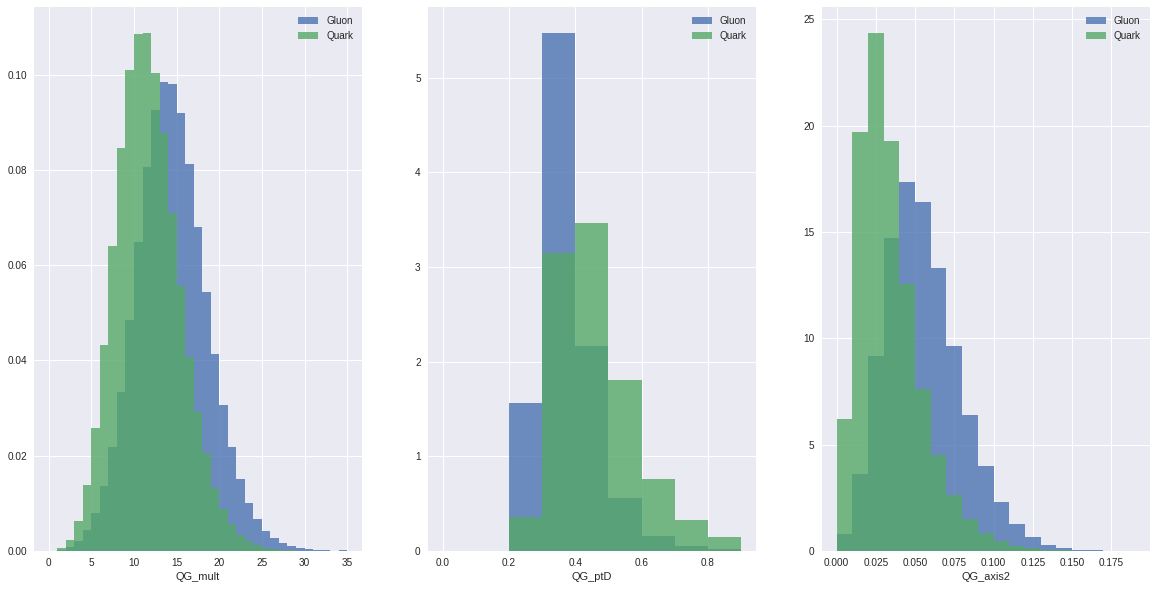

In [4]:
columns=['QG_mult','QG_ptD','QG_axis2']
binnings=[np.arange(0.0,36.0,1.0),np.arange(0.0,1.0,0.1),np.arange(0.0,0.2,0.01)]
ind=0
fig,axes = plt.subplots(1,3,figsize=(20,10))
for column in columns:
    axes[ind].hist(df_[df_['target']==1][column],bins=binnings[ind],alpha=0.8,label='Gluon',normed=1)
    axes[ind].hist(df_[df_['target']==0][column],bins=binnings[ind],alpha=0.8,label='Quark',normed=1)
    axes[ind].set_xlabel(column)
    axes[ind].legend()
    ind=ind+1

Clearly there are some differences. For example chosing jets with more than 20 charged particles and minor axis value larger than 0.1 would contain mostly gluon jets. However we can do better by using a machine learning algorithm to learn these decision rules for us.

# Keras - Tool for Deep Learning

Keras provides a very simple interface to very powerful deep learning libraries like TensorFlow by Google. It is the framework of preference for many in the particle physics community. Next we'll demonstrate that with just a few lines of code, we can produce a neural network classifier that is able to separate quark and gluon jets quite well.

In [5]:
#Importing some functions from keras and initializing it

import tensorflow as tf
import keras.backend as K
sess = tf.Session()
K.set_session(sess)

from keras_tqdm import TQDMNotebookCallback
from keras.models import Model
from keras.layers import Input,Dense
from sklearn.utils import class_weight

#Split the data into training and test sample so that we test on data we havent
#used in training. We split target to a separate dataframe so we dont use it in
#training
train_x,test = train_test_split(df_,test_size=0.15,random_state=7)
train_y = np.array(train_x.target)
train_x = np.array(train_x.drop(['target'],axis=1))

#Defining the network shape
a_inp = Input(shape=(train_x.shape[1],))
a = Dense(50,activation='relu')(a_inp)
a = Dense(50,activation='relu')(a)
a = Dense(50,activation='relu')(a)
a_out = Dense(1,activation='sigmoid')(a)
model = Model(inputs=a_inp,outputs=a_out)
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['acc'])

#weight the training samples so that there is equal weight on gluon and quark jets
#even if there are different amount of them
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_y),train_y[:])

#Perform the training
model.fit(train_x,train_y,epochs=10,batch_size=1024,class_weight=class_weights,
         validation_split=0.1,shuffle=True,verbose=0, callbacks=[TQDMNotebookCallback()])

Using TensorFlow backend.
2017-11-03 09:31:21.586062: I tensorflow/compiler/xla/service/platform_util.cc:58] platform Host present with 4 visible devices
2017-11-03 09:31:21.586558: I tensorflow/compiler/xla/service/service.cc:183] XLA service 0xd01cbf0 executing computations on platform Host. Devices:
2017-11-03 09:31:21.586578: I tensorflow/compiler/xla/service/service.cc:191]   StreamExecutor device (0): <undefined>, <undefined>


Using the trained model, we can predict the classes of jets based on the three input variables. Let as create predictions for the test set and see how much our predictions separate the quark and gluon jets from each other.

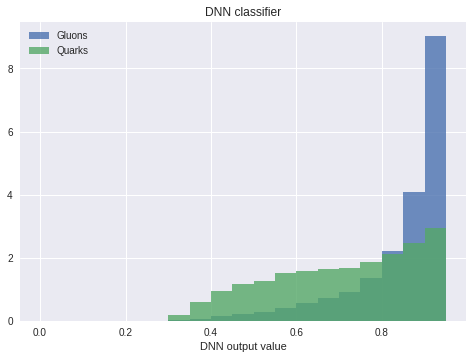

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
test.loc[:,'predictions']=model.predict(np.array(test[['QG_mult','QG_ptD','QG_axis2']].copy()))

plt.clf()
binning=np.arange(0.0,1.0,0.05)
plt.hist(test[test['target']==1]['predictions'],bins=binning,alpha=0.8,label="Gluons",normed=1)
plt.hist(test[test['target']==0]['predictions'],bins=binning,alpha=0.8,label="Quarks",normed=1)
plt.legend()
plt.xlabel('DNN output value')
plt.title('DNN classifier')

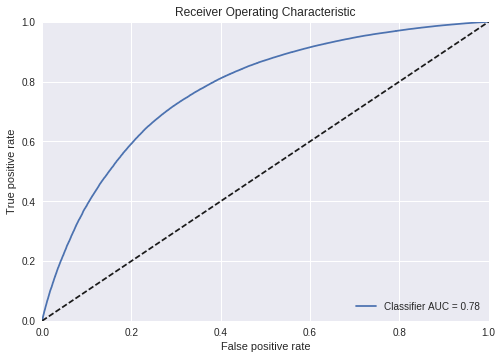

In [7]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
fpr,tpr, thresholds  = roc_curve(np.array(test['target']),np.array(test['predictions']))
roc_auc = auc(fpr, tpr)


plt.clf()
plt.plot(fpr,tpr,'b',label='Classifier AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.title("Receiver Operating Characteristic")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('roc_curve.png')

The new variable shows better separation between quark and gluon jets than any of the three variables on their own. However the strength of Deep neural networks is not in the use of this type of high level variables, but instead using very low level features and find a new representation of the data that optimizes the discrimination power. 

The dataset contains variables with prefixes Cpfcand and Npfcand. These are the particles that belong to the jet. We try adding this information and use a larger network to see if it can extract extra information from these low level features to discriminate between the quarks and gluons better.

In [8]:
data_=data.copy()
data_['target']=data['isPhysG']
data_=data_.drop(['isPhysG','isPhysUD'],axis=1)
train_x,test = train_test_split(data_,test_size=0.15,random_state=7)
train_y = np.array(train_x.target)
train_x = np.array(train_x.drop(['target'],axis=1))

a_inp = Input(shape=(train_x.shape[1],))
a = Dense(250,activation='relu')(a_inp)
a = Dense(100,activation='relu')(a)
a = Dense(50,activation='relu')(a)
a_out = Dense(1,activation='sigmoid')(a)
model = Model(inputs=a_inp,outputs=a_out)
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['acc'])

model.fit(train_x,train_y,epochs=6,batch_size=1024,class_weight=class_weights,
         validation_split=0.1,shuffle=True,verbose=0, callbacks=[TQDMNotebookCallback()])

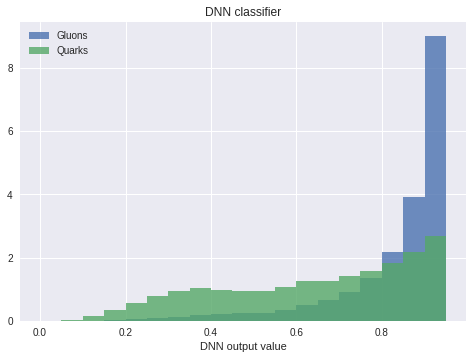

In [9]:
test.loc[:,'predictions']=model.predict(np.array(test.drop(['target'],axis=1).copy()))

plt.clf()
binning=np.arange(0.0,1.0,0.05)
plt.hist(test[test['target']==1]['predictions'],bins=binning,alpha=0.8,label="Gluons",normed=1)
plt.hist(test[test['target']==0]['predictions'],bins=binning,alpha=0.8,label="Quarks",normed=1)
plt.legend()
plt.xlabel('DNN output value')
plt.title('DNN classifier')

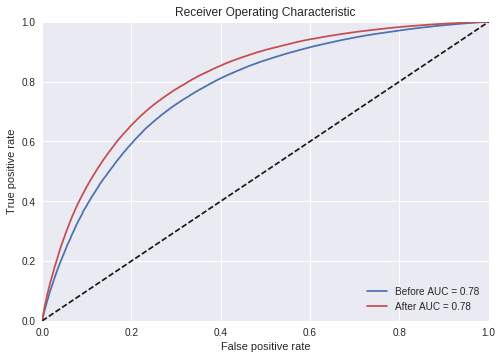

In [11]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
fpr_,tpr_, thresholds  = roc_curve(np.array(test['target']),np.array(test['predictions']))
roc_auc = auc(fpr, tpr)


plt.clf()
plt.plot(fpr,tpr,'b',label='Before AUC = %0.2f'% roc_auc)
plt.plot(fpr_,tpr_,'r',label='After AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.title("Receiver Operating Characteristic")
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('roc_curve.png')


Adding new variables increased the accuracy of the classifier. However the performance can be further enhanced with more complex networks, preprocessing input variables with PCA whitening, and adding more input variables. But for this exercise this is enough.